<h1>CNN model za prepoznavanje šalica</h1>
<hr/>
<h2>Iteracija Hotel</h2>

<p> Set slika je 700/100, Dropot i Data Augmentation i regularizacija</p>
<p>promjene na Dropoutu</p>

In [12]:
import os
import random
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout, SpatialDropout2D

import matplotlib.pyplot as plt
import numpy as np

<p>Postavljanje direktorija sa trening i validacijskim slikama:</p>

In [3]:
# Postavi direktorije slika
train_dir = "../../Projekt_slike_128/Trening"
test_dir = "../../Projekt_slike_128/Validacija"

<h5>Postavljanje sjemena:</h5>

In [36]:
seed = 77
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
os.environ['TF_DETERMINISTIC_OPS'] = '1'

<h3> Funkcija za određivanje broja epoha, veličinu batcheva i generiranje podataka</h3>

In [37]:
def generate_epochs_batchs_data():
    """ određivanje i priprema podataka """
    # Odredi broj epoha i veličinu batcheva
    num_of_epochs = input("Number of epochs:")
    num_of_epochs = int(num_of_epochs)
    size_of_batch = input("Batch size:")
    size_of_batch = int(size_of_batch)
    # Generator podataka sa augmentacijom za trening
    train_datagen = ImageDataGenerator(
        rescale=1.0 / 255,
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode="nearest",
    )
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir, target_size=(128, 128), batch_size=size_of_batch, class_mode="categorical"
    )
    return(train_generator,test_generator, num_of_epochs, size_of_batch)

In [5]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 2
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


<h3>Funkcija za plotanje rezultata </h3>

In [15]:
def plots_and_evaluation(history):
    """ funkcija za plotanje točnosti i gubitka  """
    # Plot trening i valuacija - točnost
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history["accuracy"])
    plt.plot(history.history["val_accuracy"])
    plt.title("Model accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")

    # Plot trening i validacija - gubitak
    plt.subplot(1, 2, 2)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Train", "Validation"], loc="upper left")
    plt.show()


<p>Prikaz random primjera slika:</p>

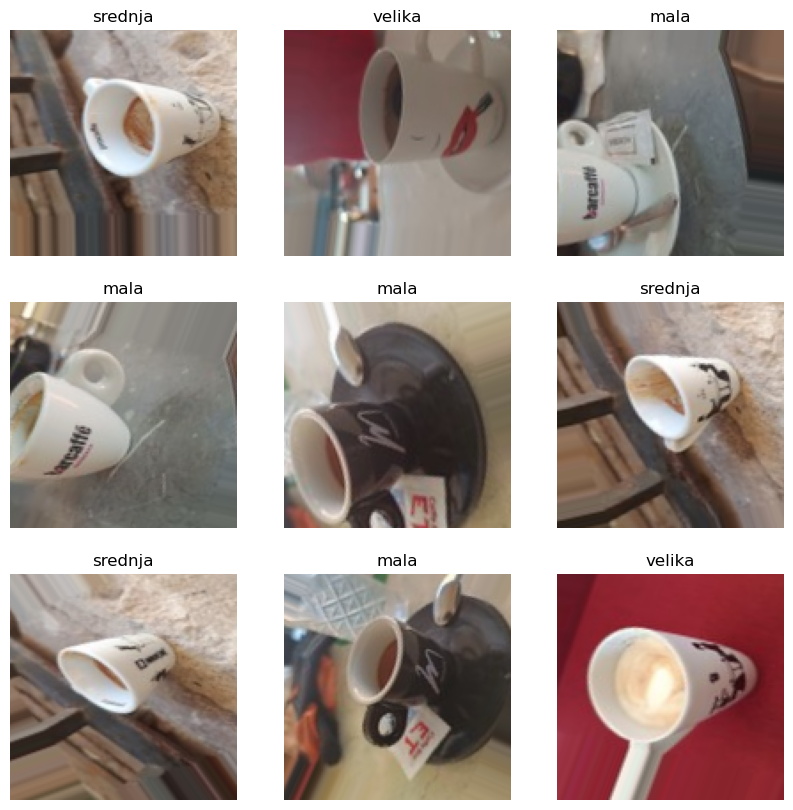

In [7]:
# Primjeri slika
def display_sample_images(generator):
    x, y = next(generator)
    plt.figure(figsize=(10, 10))
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(x[i])
        
        if (np.argmax(y[i])==0):
            plt.title("mala")
        if (np.argmax(y[i])==1):
            plt.title("srednja")
        if (np.argmax(y[i])==2):
            plt.title("velika")
        plt.axis("off")
    plt.show()


display_sample_images(train_generator)

<h2> Iteracija H.1</h2>
<p>dodana L2 regularizacija i Dropout</p>
<p> batch 64, epochs 100, parametri 3 000 000</p>


In [16]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [17]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu"),
        
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 63, 63, 8)         0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_6 (Spati  (None, 63, 63, 8)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_7 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 30, 30, 16)        0         
 g2D)                                                            
                                                      

In [18]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-20 07:19:14.384428: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/spatial_dropout2d_6/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 839ms/step - loss: 1.1994 - accuracy: 0.3389 - val_loss: 1.1049 - val_accuracy: 0.5547
Epoch 2/100
32/32 [==============================] - 28s 867ms/step - loss: 1.1056 - accuracy: 0.3929 - val_loss: 1.1050 - val_accuracy: 0.3242
Epoch 3/100
32/32 [==============================] - 28s 870ms/step - loss: 1.0968 - accuracy: 0.3988 - val_loss: 1.1005 - val_accuracy: 0.3359
Epoch 4/100
32/32 [==============================] - 28s 859ms/step - loss: 1.0864 - accuracy: 0.4155 - val_loss: 1.0855 - val_accuracy: 0.4023
Epoch 5/100
32/32 [==============================] - 28s 874ms/step - loss: 1.0698 - accuracy: 0.4307 - val_loss: 1.0823 - val_accuracy: 0.3828
Epoch 6/100
32/32 [==============================] - 28s 865ms/step - loss: 1.0645 - accuracy: 0.4445 - val_loss: 1.1114 - val_accuracy: 0.3320
Epoch 7/100
32/32 [==============================] - 28s 880ms/step - loss: 1.0680 - accuracy: 0.4352 - val_loss: 1.0315 - val_accuracy: 0.4766
Epoc

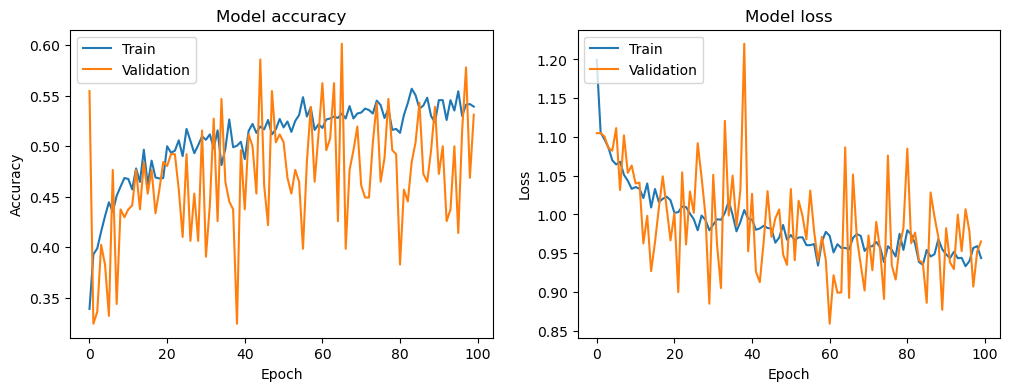

4/4 [==============================] - 1s 151ms/step - loss: 0.9587 - accuracy: 0.5391
Test accuracy: 0.5390625


In [19]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Iteracija H.2</h2>
<p>dodana L2 regularizacija i Dropout</p>
<p> batch 128, epochs 100, parametri 3 000 000</p>

In [21]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 100
Batch size: 128


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [22]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu"),
        
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_9 (MaxPoolin  (None, 63, 63, 8)         0         
 g2D)                                                            
                                                                 
 spatial_dropout2d_9 (Spati  (None, 63, 63, 8)         0         
 alDropout2D)                                                    
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [23]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/100


2024-08-20 08:10:12.331131: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_3/spatial_dropout2d_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


16/16 [==============================] - 35s 2s/step - loss: 1.4320 - accuracy: 0.3423 - val_loss: 1.1092 - val_accuracy: 0.3477
Epoch 2/100
16/16 [==============================] - 28s 2s/step - loss: 1.1474 - accuracy: 0.3129 - val_loss: 1.1085 - val_accuracy: 0.3125
Epoch 3/100
16/16 [==============================] - 27s 2s/step - loss: 1.1133 - accuracy: 0.3453 - val_loss: 1.1079 - val_accuracy: 0.3750
Epoch 4/100
16/16 [==============================] - 27s 2s/step - loss: 1.1098 - accuracy: 0.3519 - val_loss: 1.1070 - val_accuracy: 0.3359
Epoch 5/100
16/16 [==============================] - 27s 2s/step - loss: 1.1070 - accuracy: 0.3626 - val_loss: 1.1054 - val_accuracy: 0.3594
Epoch 6/100
16/16 [==============================] - 27s 2s/step - loss: 1.1044 - accuracy: 0.3707 - val_loss: 1.1048 - val_accuracy: 0.3516
Epoch 7/100
16/16 [==============================] - 27s 2s/step - loss: 1.1050 - accuracy: 0.3727 - val_loss: 1.1044 - val_accuracy: 0.3398
Epoch 8/100
16/16 [======

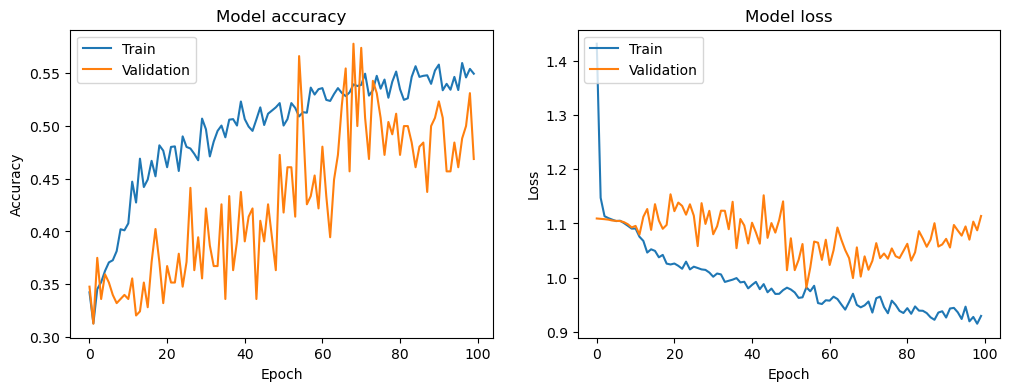

2/2 [==============================] - 1s 227ms/step - loss: 1.0863 - accuracy: 0.4844
Test accuracy: 0.484375


In [24]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Iteracija H.3</h2>
<p>dodana L2 regularizacija i Dropout smanjen na 0.3</p>
<p> batch 64, epochs 200, parametri 3 000 000</p>

In [26]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 200
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [38]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.3),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.3),
        Conv2D(32, (3, 3), activation="relu"),
        
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.3),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.3),
        Dense(128, activation="relu"),
        Dropout(0.3),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_18 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_18 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_18 (Spat  (None, 63, 63, 8)         0         
 ialDropout2D)                                                   
                                                                 
 conv2d_19 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_19 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [39]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/75


2024-08-20 13:16:20.935817: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_6/spatial_dropout2d_18/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 839ms/step - loss: 1.1338 - accuracy: 0.3369 - val_loss: 1.0992 - val_accuracy: 0.6602
Epoch 2/75
32/32 [==============================] - 28s 855ms/step - loss: 1.0898 - accuracy: 0.3846 - val_loss: 1.0634 - val_accuracy: 0.5391
Epoch 3/75
32/32 [==============================] - 28s 861ms/step - loss: 1.0650 - accuracy: 0.4288 - val_loss: 1.0067 - val_accuracy: 0.5547
Epoch 4/75
32/32 [==============================] - 28s 854ms/step - loss: 1.0362 - accuracy: 0.4710 - val_loss: 1.0319 - val_accuracy: 0.4375
Epoch 5/75
32/32 [==============================] - 28s 854ms/step - loss: 1.0105 - accuracy: 0.5029 - val_loss: 0.9701 - val_accuracy: 0.5117
Epoch 6/75
32/32 [==============================] - 28s 860ms/step - loss: 1.0051 - accuracy: 0.5029 - val_loss: 1.0079 - val_accuracy: 0.4297
Epoch 7/75
32/32 [==============================] - 28s 860ms/step - loss: 1.0134 - accuracy: 0.4936 - val_loss: 0.9594 - val_accuracy: 0.4648
Epoch 8/75

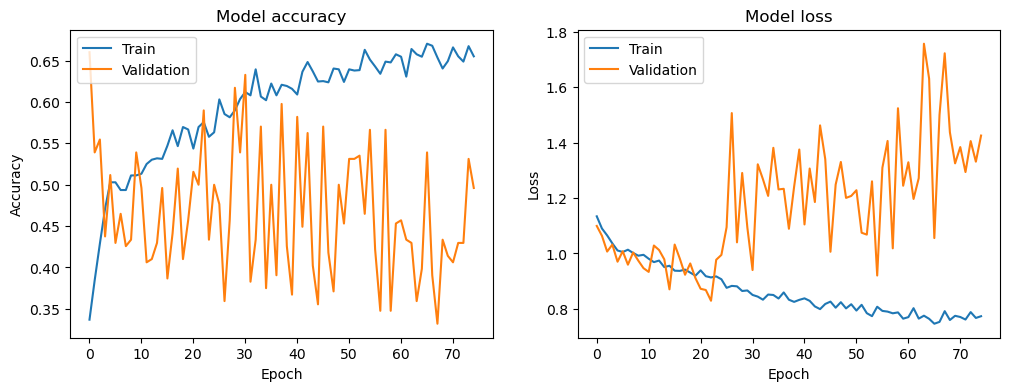

4/4 [==============================] - 1s 123ms/step - loss: 1.3950 - accuracy: 0.5078
Test accuracy: 0.5078125


In [40]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Iteracija H.4</h2>
<p>dodana L2 regularizacija i Dropout 0.4</p>
<p> batch 64, epochs 75, parametri 3 000 000</p>

In [41]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 75
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [42]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Conv2D(32, (3, 3), activation="relu"),
        
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.4),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.4),
        Dense(128, activation="relu"),
        Dropout(0.4),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_21 (Spat  (None, 63, 63, 8)         0         
 ialDropout2D)                                                   
                                                                 
 conv2d_22 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [43]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/75


2024-08-20 13:58:00.014189: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_7/spatial_dropout2d_21/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 33s 848ms/step - loss: 1.1929 - accuracy: 0.3163 - val_loss: 1.1049 - val_accuracy: 0.2891
Epoch 2/75
32/32 [==============================] - 28s 857ms/step - loss: 1.1046 - accuracy: 0.3610 - val_loss: 1.1045 - val_accuracy: 0.3438
Epoch 3/75
32/32 [==============================] - 28s 865ms/step - loss: 1.1033 - accuracy: 0.3738 - val_loss: 1.1147 - val_accuracy: 0.3398
Epoch 4/75
32/32 [==============================] - 28s 863ms/step - loss: 1.0903 - accuracy: 0.3836 - val_loss: 1.1310 - val_accuracy: 0.3594
Epoch 5/75
32/32 [==============================] - 28s 859ms/step - loss: 1.0675 - accuracy: 0.4288 - val_loss: 1.2412 - val_accuracy: 0.3398
Epoch 6/75
32/32 [==============================] - 28s 857ms/step - loss: 1.0367 - accuracy: 0.4617 - val_loss: 1.1161 - val_accuracy: 0.4570
Epoch 7/75
32/32 [==============================] - 28s 858ms/step - loss: 1.0203 - accuracy: 0.4759 - val_loss: 1.2528 - val_accuracy: 0.4453
Epoch 8/75

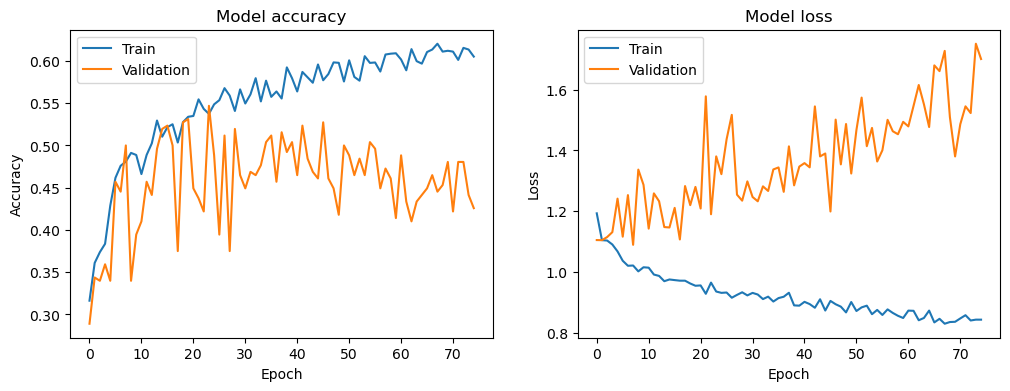

4/4 [==============================] - 1s 167ms/step - loss: 1.6328 - accuracy: 0.4336
Test accuracy: 0.43359375


In [44]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<h2> Iteracija H.5</h2>
<p>dodana L2 regularizacija i Dropout JE 0.5</p>
<p> batch 64, epochs 200, parametri 3 000 000</p>

In [46]:
traintest_generators = generate_epochs_batchs_data()
train_generator = traintest_generators[0]
test_generator = traintest_generators[1]
num_of_epochs = traintest_generators[2]
size_of_batch = traintest_generators[3]

Number of epochs: 75
Batch size: 64


Found 2100 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


In [47]:
# CNN model
model = Sequential(
    [
        Conv2D(8, (3, 3), activation="relu", input_shape=(128, 128, 3)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(16, (3, 3), activation="relu", kernel_regularizer=l2(0.001)),
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Conv2D(32, (3, 3), activation="relu"),
        
        MaxPooling2D((2, 2)),
        SpatialDropout2D(0.5),
        Flatten(),
        Dense(512, activation="relu"),
        Dropout(0.5),
        Dense(128, activation="relu"),
        Dropout(0.5),
        Dense(3, activation="softmax"),
    ]
)
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_24 (Conv2D)          (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 63, 63, 8)         0         
 ng2D)                                                           
                                                                 
 spatial_dropout2d_24 (Spat  (None, 63, 63, 8)         0         
 ialDropout2D)                                                   
                                                                 
 conv2d_25 (Conv2D)          (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 30, 30, 16)        0         
 ng2D)                                                           
                                                      

In [48]:
# Kompajliranje
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# Treniranje
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    epochs=num_of_epochs,
    validation_data=test_generator,
    validation_steps=test_generator.samples // test_generator.batch_size,
)

Epoch 1/75


2024-08-20 15:49:13.952774: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_8/spatial_dropout2d_24/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


32/32 [==============================] - 48s 1s/step - loss: 1.1574 - accuracy: 0.3409 - val_loss: 1.1046 - val_accuracy: 0.3594
Epoch 2/75
32/32 [==============================] - 28s 859ms/step - loss: 1.0965 - accuracy: 0.3767 - val_loss: 1.0946 - val_accuracy: 0.4414
Epoch 3/75
32/32 [==============================] - 28s 856ms/step - loss: 1.0759 - accuracy: 0.4244 - val_loss: 1.0835 - val_accuracy: 0.4102
Epoch 4/75
32/32 [==============================] - 28s 853ms/step - loss: 1.0683 - accuracy: 0.4244 - val_loss: 1.0582 - val_accuracy: 0.4609
Epoch 5/75
32/32 [==============================] - 28s 866ms/step - loss: 1.0668 - accuracy: 0.4322 - val_loss: 1.0908 - val_accuracy: 0.3984
Epoch 6/75
32/32 [==============================] - 28s 858ms/step - loss: 1.0362 - accuracy: 0.4583 - val_loss: 1.0589 - val_accuracy: 0.4102
Epoch 7/75
32/32 [==============================] - 27s 855ms/step - loss: 1.0464 - accuracy: 0.4411 - val_loss: 1.0458 - val_accuracy: 0.4219
Epoch 8/75
32

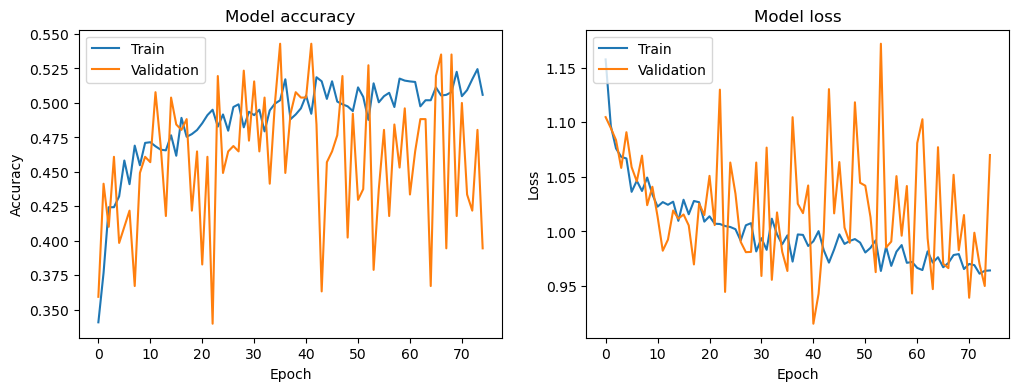

4/4 [==============================] - 1s 127ms/step - loss: 1.0636 - accuracy: 0.3984
Test accuracy: 0.3984375


In [49]:
#Plotovi
plots_and_evaluation(history)
# Evaluacija modela
test_loss, test_acc = model.evaluate(
    test_generator, steps=test_generator.samples // test_generator.batch_size
)
print("Test accuracy:", test_acc)

<p>Zaključak:</p>
<p>doadvanje Dropouta donijelo je neke male pomake na modelima sa batch_size 64</p>
<p>Sljedeći korak: isprobati najbolji H i G model sa izmjenjenom Data Augmentacijom</p>